# Bias in AI Gaming: Final Analysis (Cleaned Version)

This version retains key visual outputs and removes redundant code or comments.


# 📘 Bias in AI Gaming - Final Analysis Notebook

This notebook merges content from both `Bias_in_ai_gaming.ipynb` and `final.ipynb` for a comprehensive view.


## 📂 Section 1: Bias in AI Gaming


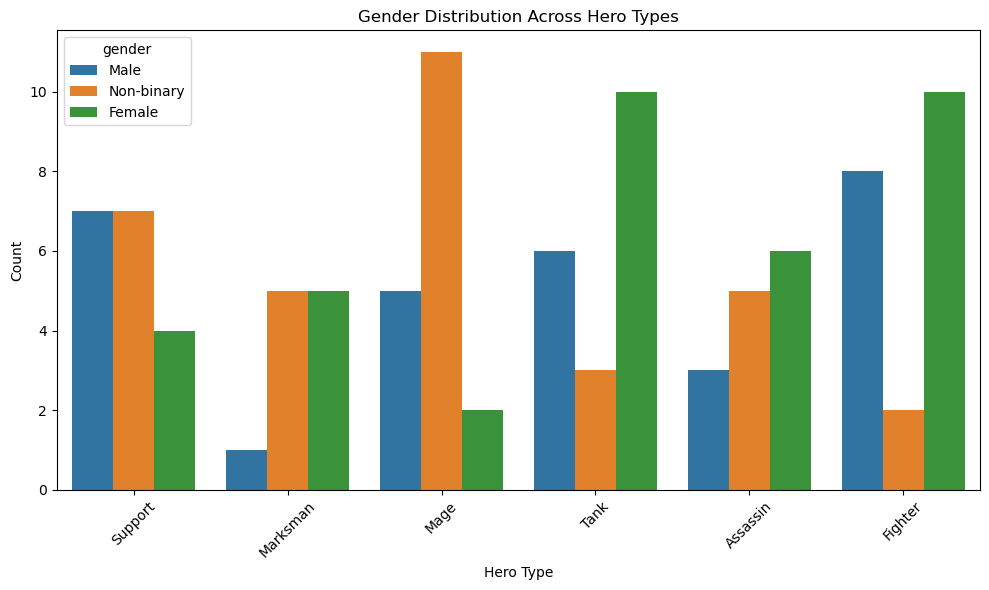

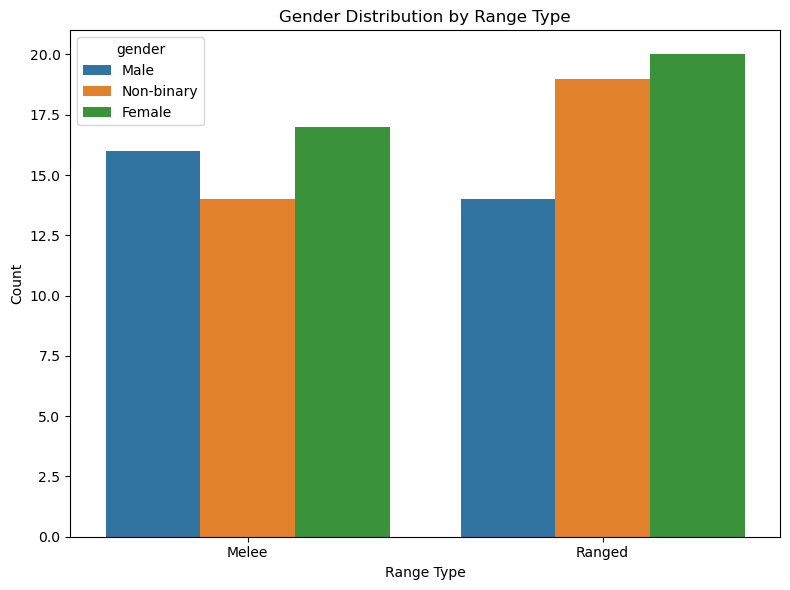

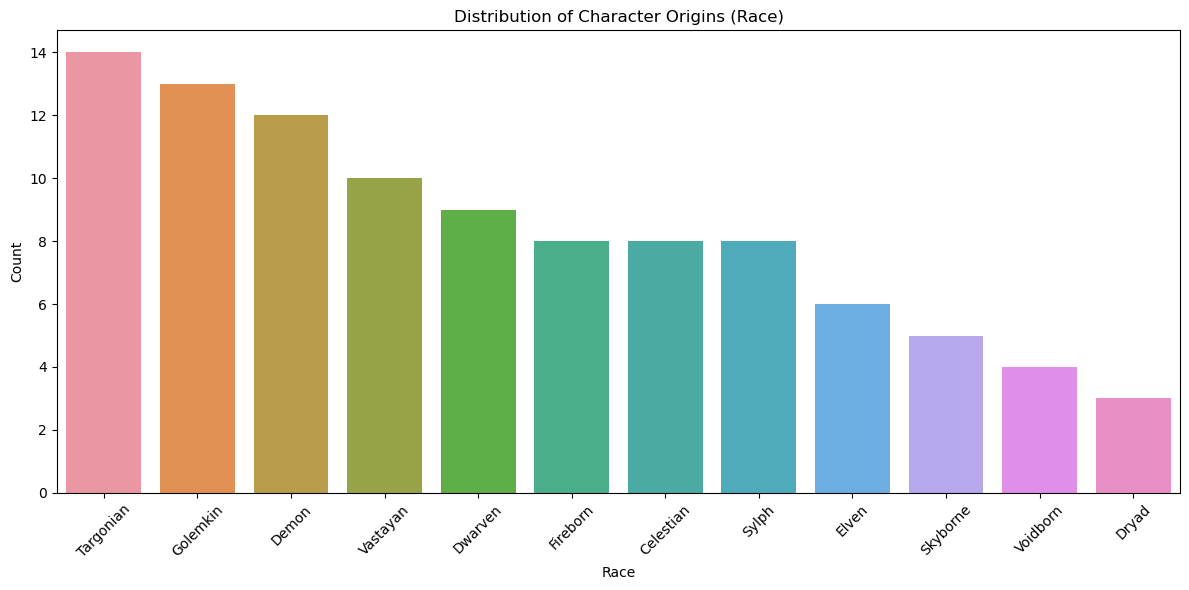

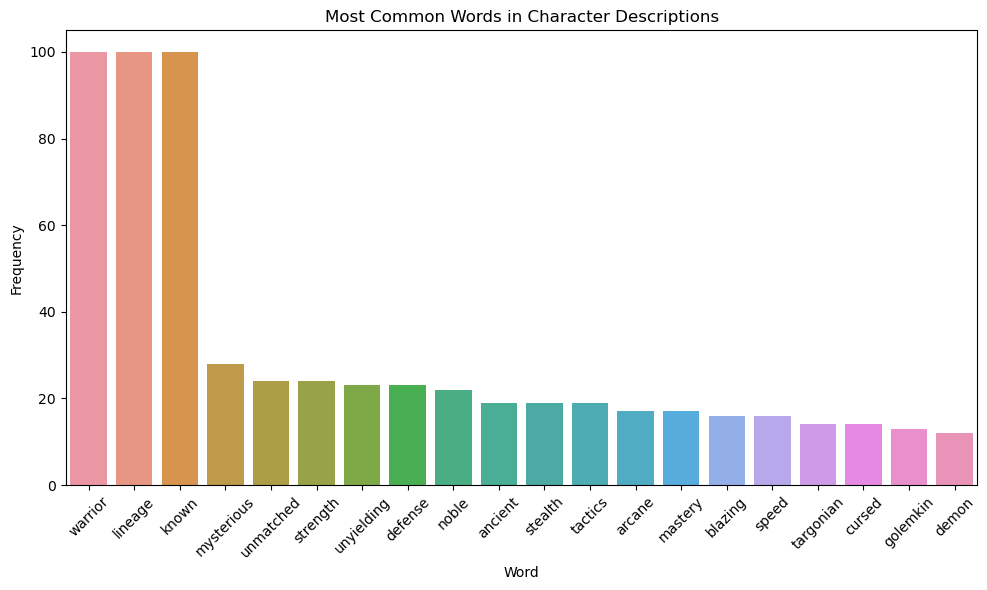

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

df = pd.read_csv("data1.csv")

df['gender'] = df['gender'].str.strip()
df['herotype'] = df['herotype'].str.strip()
df['alttype'] = df['alttype'].str.strip()
df['rangetype'] = df['rangetype'].str.strip()
df['race'] = df['race'].str.strip()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='herotype', hue='gender')
plt.title('Gender Distribution Across Hero Types')
plt.xlabel('Hero Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rangetype', hue='gender')
plt.title('Gender Distribution by Range Type')
plt.xlabel('Range Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='race', order=df['race'].value_counts().index)
plt.title('Distribution of Character Origins (Race)')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

descriptions = ' '.join(df['description'].dropna()).lower()
words = re.findall(r'\b[a-z]{3,}\b', descriptions)  # Only words with 3+ letters
filtered_words = [w for w in words if w not in ENGLISH_STOP_WORDS]

word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words in Character Descriptions')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

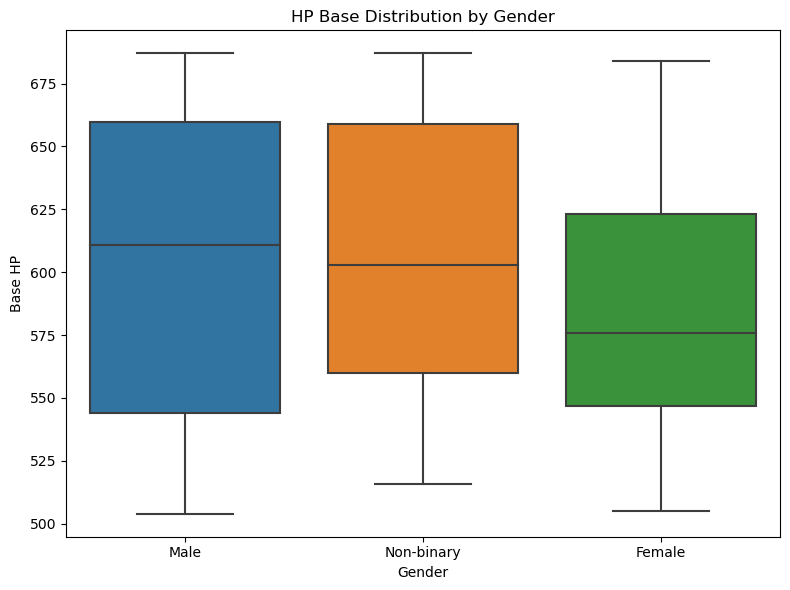

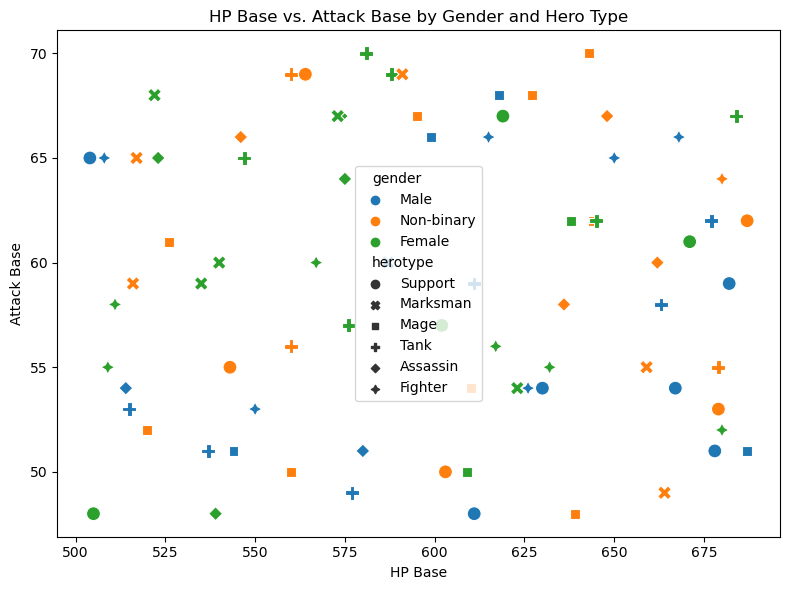

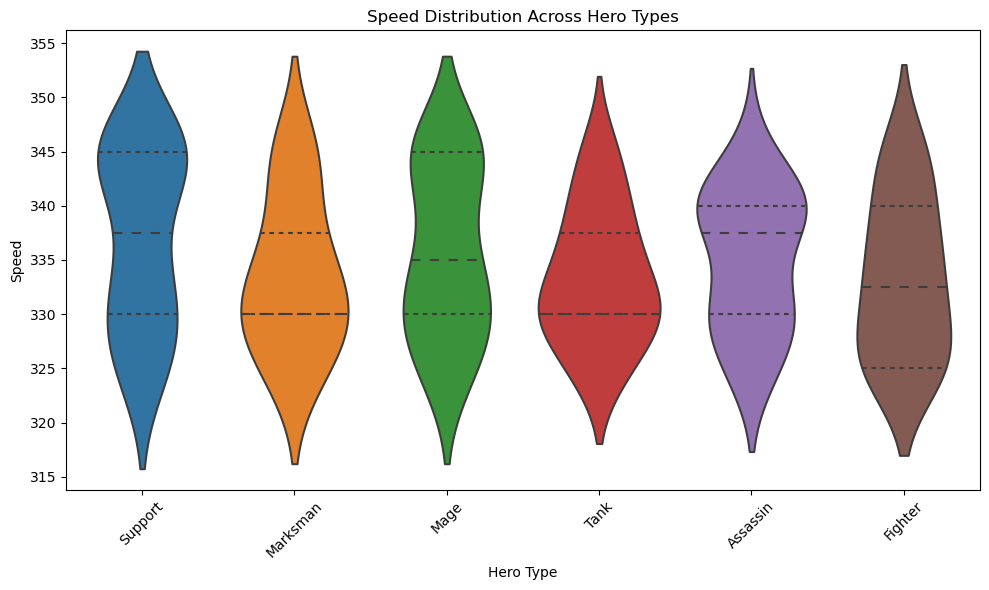

c:\Users\kevin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


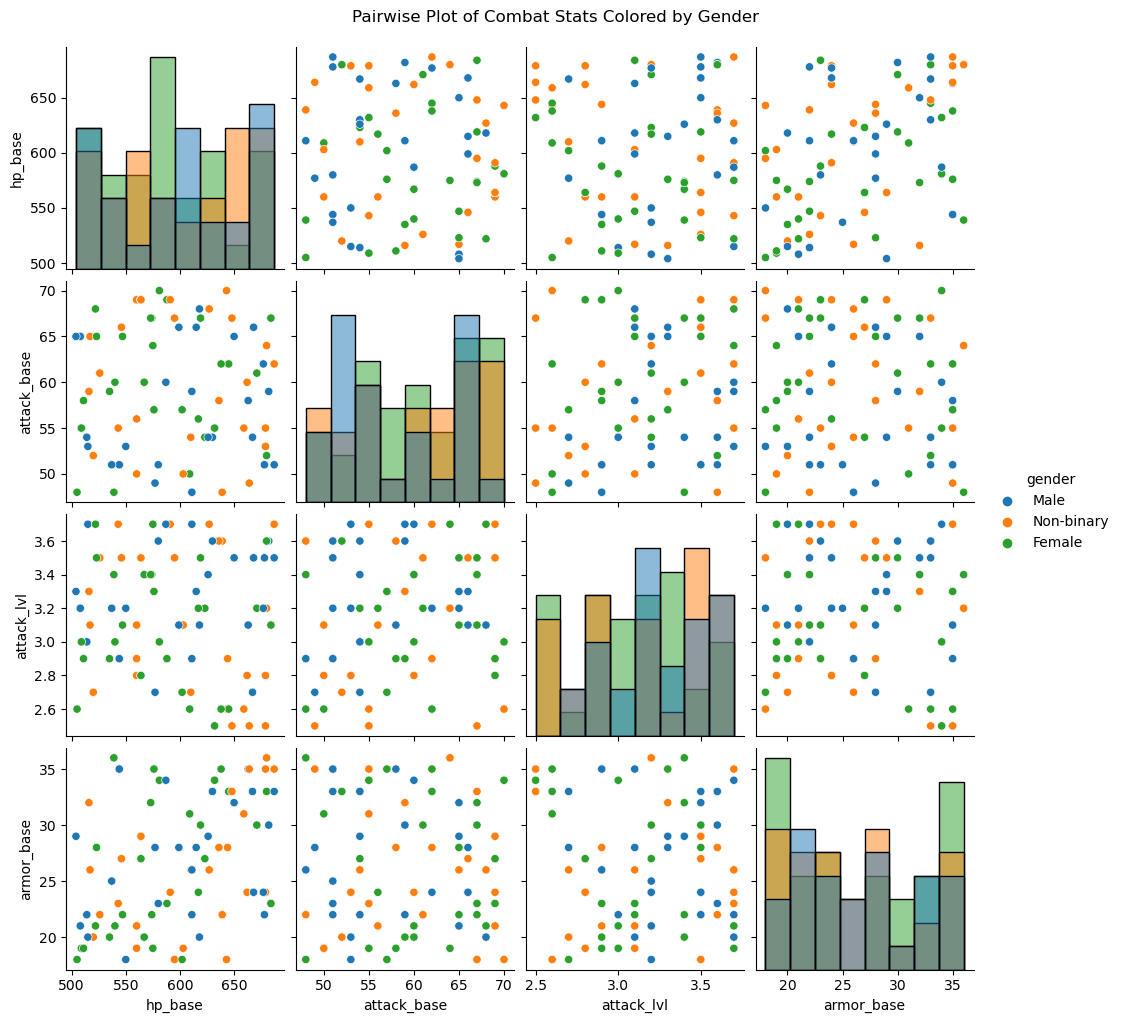

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

df = pd.read_csv("data1.csv")
df['gender'] = df['gender'].str.strip()
df['herotype'] = df['herotype'].str.strip()
df['alttype'] = df['alttype'].str.strip()
df['rangetype'] = df['rangetype'].str.strip()
df['race'] = df['race'].str.strip()

df['parsed_stats'] = df['stats'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
stats_df = pd.json_normalize(df['parsed_stats'])
df_stats = pd.concat([df, stats_df], axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_stats, x='gender', y='hp_base')
plt.title('HP Base Distribution by Gender')
plt.ylabel('Base HP')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_stats, x='hp_base', y='attack_base', hue='gender', style='herotype', s=100)
plt.title('HP Base vs. Attack Base by Gender and Hero Type')
plt.xlabel('HP Base')
plt.ylabel('Attack Base')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_stats, x='herotype', y='speed', inner='quartile')
plt.title('Speed Distribution Across Hero Types')
plt.xticks(rotation=45)
plt.xlabel('Hero Type')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

combat_features = ['hp_base', 'attack_base', 'attack_lvl', 'armor_base']
plot_df = df_stats[combat_features + ['gender']].dropna()
plot_df = plot_df[plot_df['gender'].apply(lambda x: isinstance(x, str))]
for col in combat_features:
    plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')
plot_df = plot_df.dropna()

sns.pairplot(plot_df, hue='gender', diag_kind='hist')
plt.suptitle('Pairwise Plot of Combat Stats Colored by Gender', y=1.02)
plt.show()

Initial Gender Prediction Accuracy: 0.4000
              precision    recall  f1-score   support

      Female       0.36      0.67      0.47         6
        Male       0.50      0.25      0.33         8
  Non-binary       0.40      0.33      0.36         6

    accuracy                           0.40        20
   macro avg       0.42      0.42      0.39        20
weighted avg       0.43      0.40      0.38        20



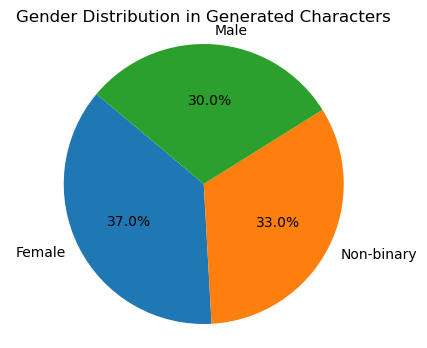

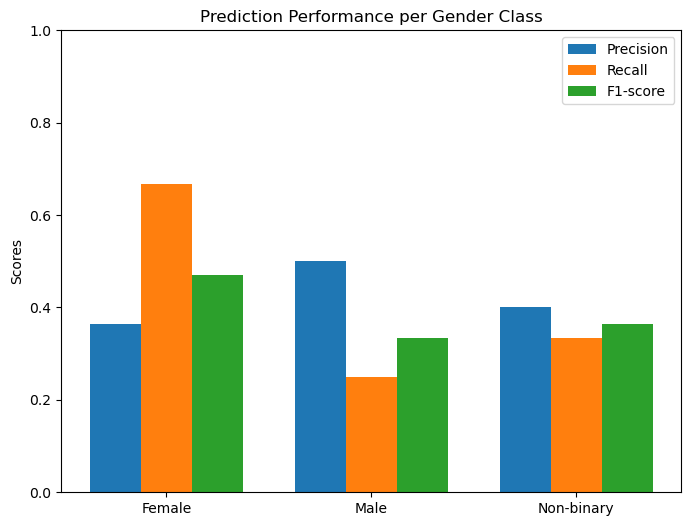

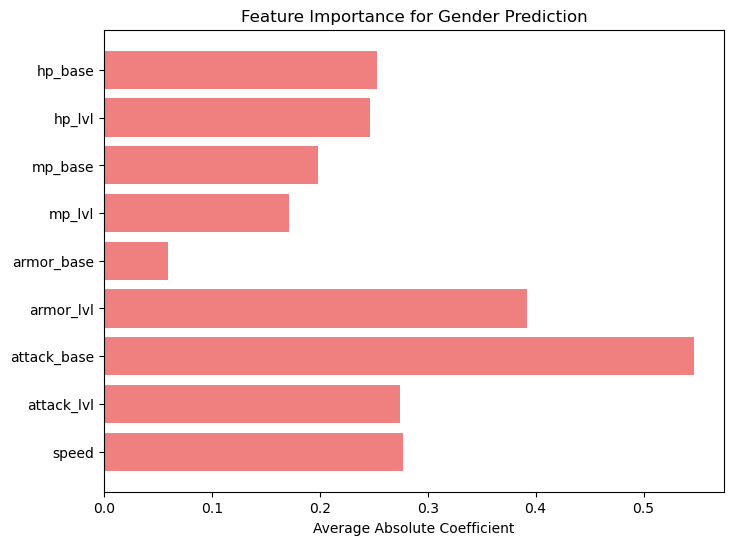

In [18]:

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support

df = pd.read_csv('data1.csv')

df['stats'] = df['stats'].apply(ast.literal_eval)

stats_df = pd.json_normalize(df['stats'])

full_df = pd.concat([df, stats_df], axis=1)

feature_cols = ['hp_base', 'hp_lvl', 'mp_base', 'mp_lvl',
                'armor_base', 'armor_lvl', 'attack_base', 'attack_lvl', 'speed']

full_df = full_df[full_df['gender'].isin(['Male', 'Female', 'Non-binary'])]

X = full_df[feature_cols]
y = full_df['gender']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Initial Gender Prediction Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)


gender_counts = full_df['gender'].value_counts()
plt.figure(figsize=(5,4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution in Generated Characters')
plt.axis('equal')
plt.show()

precisions, recalls, f1s, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0,1,2])

categories = le.classes_
x = np.arange(len(categories))
width = 0.25

plt.figure(figsize=(8,6))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-score')

plt.ylabel('Scores')
plt.title('Prediction Performance per Gender Class')
plt.xticks(x, categories)
plt.ylim(0,1)
plt.legend()
plt.show()

importance = np.mean(np.abs(model.coef_), axis=0)

plt.figure(figsize=(8,6))
plt.barh(feature_cols, importance, color='lightcoral')
plt.xlabel('Average Absolute Coefficient')
plt.title('Feature Importance for Gender Prediction')
plt.gca().invert_yaxis()
plt.show()



Final Gender Prediction Accuracy (after debiasing): 0.4
Adversary Prediction Accuracy (should be low): 0.45

Classification Report after Debiasing:

              precision    recall  f1-score   support

      Female       0.38      0.43      0.40         7
        Male       0.67      0.33      0.44         6
  Non-binary       0.33      0.43      0.38         7

    accuracy                           0.40        20
   macro avg       0.46      0.40      0.41        20
weighted avg       0.45      0.40      0.40        20



c:\Users\kevin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


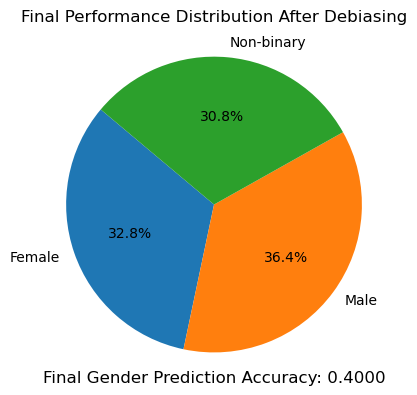

In [33]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight

df = pd.read_csv('data1.csv')
df['stats'] = df['stats'].apply(ast.literal_eval)
stats_df = pd.json_normalize(df['stats'])
full_df = pd.concat([df, stats_df], axis=1)

feature_cols = ['hp_base', 'hp_lvl', 'mp_base', 'mp_lvl',
                'armor_base', 'armor_lvl', 'attack_base', 'attack_lvl', 'speed']
full_df = full_df[full_df['gender'].isin(['Male', 'Female', 'Non-binary'])]
full_df = full_df.dropna(subset=feature_cols)

X = full_df[feature_cols]
y = full_df['gender']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

data_train = pd.concat([X_train, pd.Series(y_train, name='gender')], axis=1)
max_count = data_train['gender'].value_counts().max()
upsampled_frames = []
for label in data_train['gender'].unique():
    subset = data_train[data_train['gender'] == label]
    if len(subset) == 0:
        continue
    upsampled = resample(
        subset, replace=True, n_samples=max_count, random_state=42
    )
    upsampled_frames.append(upsampled)
resampled_train = pd.concat(upsampled_frames)
resampled_train = resampled_train.dropna(subset=feature_cols)
X_train_resampled = resampled_train[feature_cols]
y_train_resampled = resampled_train['gender']

classes = np.unique(y_train_resampled)
weights = compute_class_weight(
    class_weight='balanced', classes=classes, y=y_train_resampled
)
class_weight_dict = {cls: w for cls, w in zip(classes, weights)}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', max_iter=1000,
    class_weight=class_weight_dict
)
model.fit(X_train_scaled, y_train_resampled)

y_proba_train = model.predict_proba(X_train_scaled)
y_proba_test = model.predict_proba(X_test_scaled)
adversary = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42)
adversary.fit(y_proba_train, y_train_resampled)

y_pred = model.predict(X_test_scaled)
y_adv_pred = adversary.predict(y_proba_test)
print("Final Gender Prediction Accuracy (after debiasing):", accuracy_score(y_test, y_pred))
print("Adversary Prediction Accuracy (should be low):", accuracy_score(y_test, y_adv_pred))
print("\nClassification Report after Debiasing:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

_, _, f1_scores, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=classes, zero_division=0
)
categories = le.classes_
proportions = f1_scores / f1_scores.sum()

plt.figure(figsize=(4,4))
plt.pie(proportions, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Final Performance Distribution After Debiasing')
plt.axis('equal')
plt.tight_layout()

accuracy = accuracy_score(y_test, y_pred)
plt.text(0, -1.2, f"Final Gender Prediction Accuracy: {accuracy:.4f}", ha='center', fontsize=12)

plt.show()


---

## 📂 Section 2: Final Analysis


In [1]:
import json
import pandas as pd

file_paths = [
    "Claude50.txt",
    "claude file.txt",
    "message_cla.txt",
    "message.txt",
    "GPT50.txt",
    "gpt file.txt"
]

def extract_characters(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        start = text.find('[')
        end = text.rfind(']') + 1
        json_data = text[start:end]
        return json.loads(json_data)

def extract_characters_clean(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        start = text.find('[')
        end = text.find(']') + 1
        while text[end:end+1] == ',':
            end = text.find(']', end) + 1  # Handle nested brackets or extra closing brackets
        json_data = text[start:end]
        try:
            return json.loads(json_data)
        except json.JSONDecodeError:
            return []

all_characters_cleaned = []
for path in file_paths:
    chars = extract_characters_clean(path)
    all_characters_cleaned.extend(chars)

df_cleaned = pd.DataFrame(all_characters_cleaned)
df_cleaned["city"] = df_cleaned["city"].str.replace(r",\s*[A-Z]{2}$", "", regex=True).str.strip()



In [3]:
gender_counts = df_cleaned['gender'].value_counts()
industry_counts = df_cleaned['job_industry'].value_counts()
city_counts = df_cleaned['city'].value_counts()

avg_income_by_gender = df_cleaned.groupby('gender')['annual_income'].mean().sort_values(ascending=False)
avg_income_by_industry = df_cleaned.groupby('job_industry')['annual_income'].mean().sort_values(ascending=False)

csv_path = "cleaned_characters.csv"
df_cleaned.to_csv(csv_path, index=False)

{
    "gender_distribution": gender_counts.to_dict(),
    "job_industry_distribution": industry_counts.to_dict(),
    "city_distribution_top10": city_counts.head(10).to_dict(),
    "average_income_by_gender": avg_income_by_gender.to_dict(),
    "average_income_by_job_industry_top10": avg_income_by_industry.head(10).to_dict(),
    "csv_file": csv_path
}


{'gender_distribution': {'Female': 117, 'Male': 116, 'Non-binary': 14},
 'job_industry_distribution': {'Education': 16,
  'Healthcare': 15,
  'Information Technology': 15,
  'Creative/Design': 15,
  'Legal': 14,
  'Engineering': 14,
  'Finance': 14,
  'Marketing': 13,
  'Science and Research': 13,
  'Transportation': 13,
  'Food Service': 13,
  'Construction': 12,
  'Hospitality': 11,
  'Retail': 11,
  'Administration': 10,
  'Human Resources': 10,
  'Customer Service': 10,
  'Sales': 10,
  'Manufacturing': 9,
  'Public Safety': 9},
 'city_distribution_top10': {'Chicago': 8,
  'Denver': 8,
  'Atlanta': 8,
  'Boston': 8,
  'Portland': 8,
  'New York': 8,
  'San Francisco': 8,
  'Seattle': 7,
  'Minneapolis': 7,
  'Houston': 7},
 'average_income_by_gender': {'Male': 78534.4827586207,
  'Female': 75196.5811965812,
  'Non-binary': 75107.14285714286},
 'average_income_by_job_industry_top10': {'Legal': 128428.57142857143,
  'Finance': 107857.14285714286,
  'Engineering': 104285.71428571429,


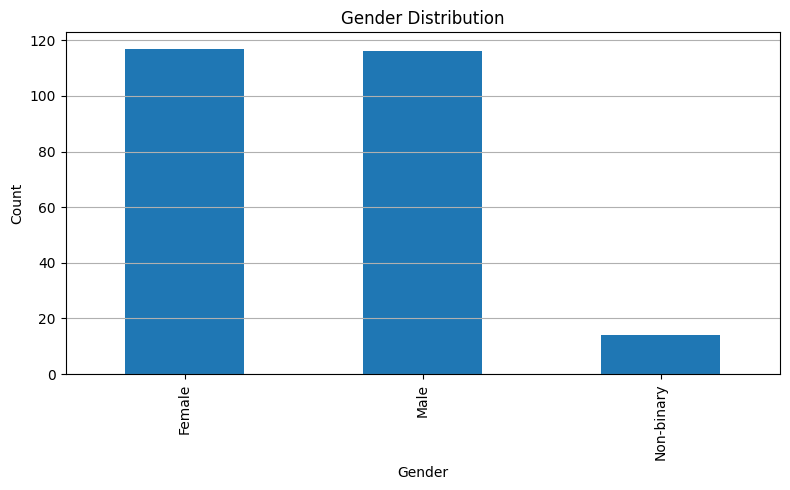

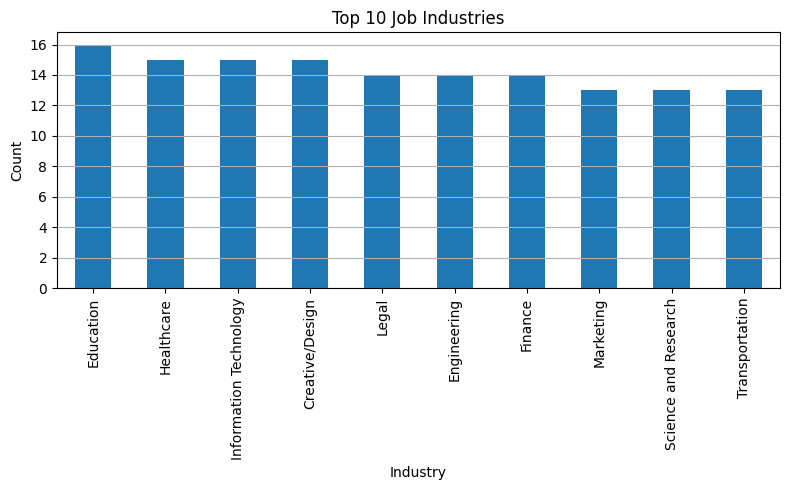

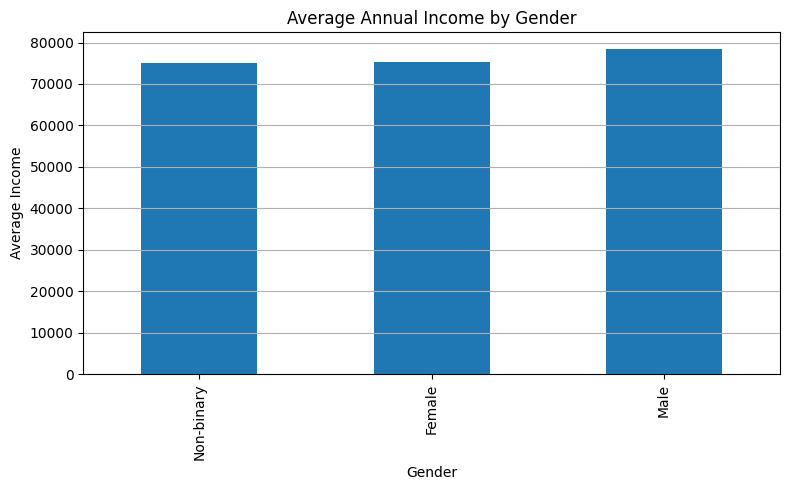

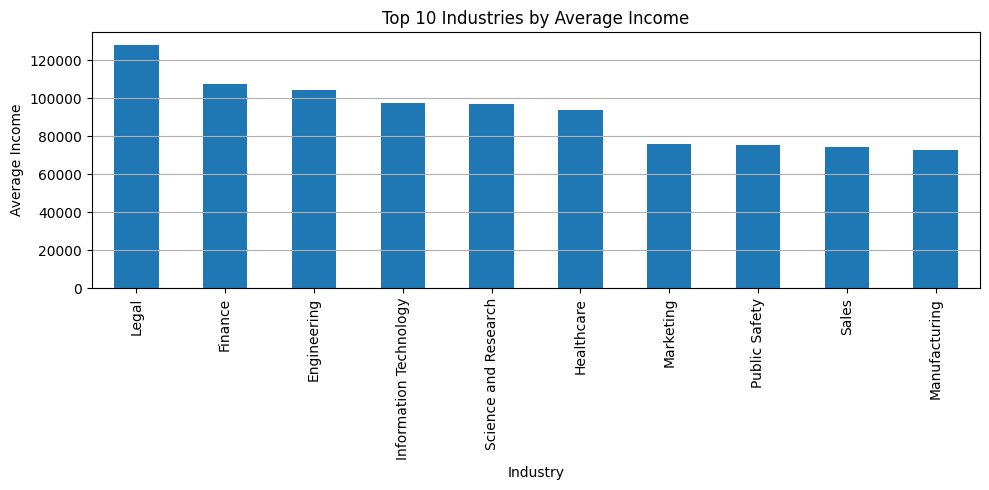

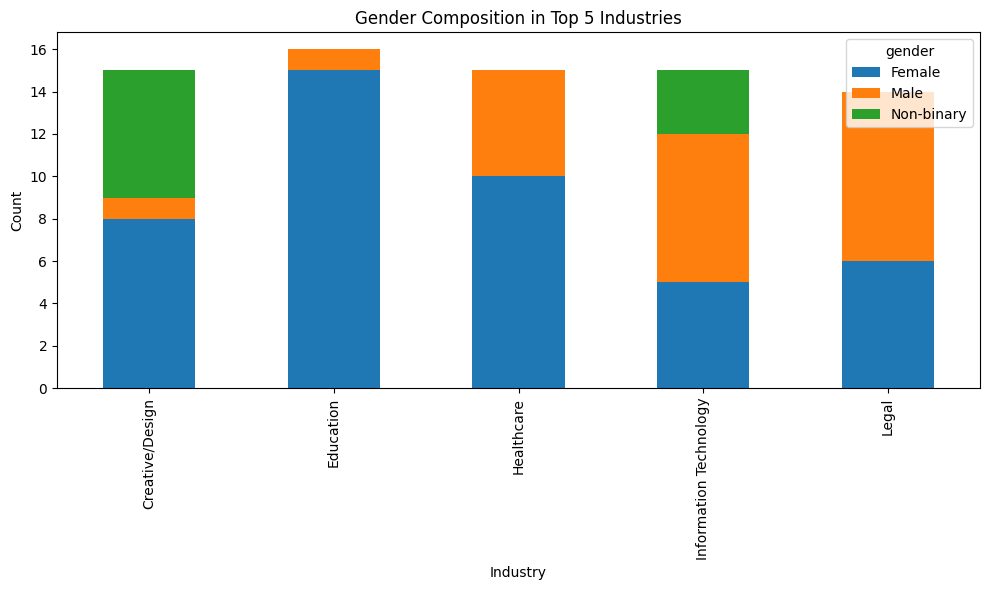

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})
figsize = (8, 5)

plt.figure(figsize=figsize)
df_cleaned['gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
df_cleaned['job_industry'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Job Industries')
plt.ylabel('Count')
plt.xlabel('Industry')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
df_cleaned.groupby('gender')['annual_income'].mean().sort_values().plot(kind='bar')
plt.title('Average Annual Income by Gender')
plt.ylabel('Average Income')
plt.xlabel('Gender')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
df_cleaned.groupby('job_industry')['annual_income'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Industries by Average Income')
plt.ylabel('Average Income')
plt.xlabel('Industry')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

top5_industries = df_cleaned['job_industry'].value_counts().head(5).index
gender_industry = df_cleaned[df_cleaned['job_industry'].isin(top5_industries)]
cross_tab = pd.crosstab(gender_industry['job_industry'], gender_industry['gender'])

cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Gender Composition in Top 5 Industries')
plt.ylabel('Count')
plt.xlabel('Industry')
plt.tight_layout()
plt.show()


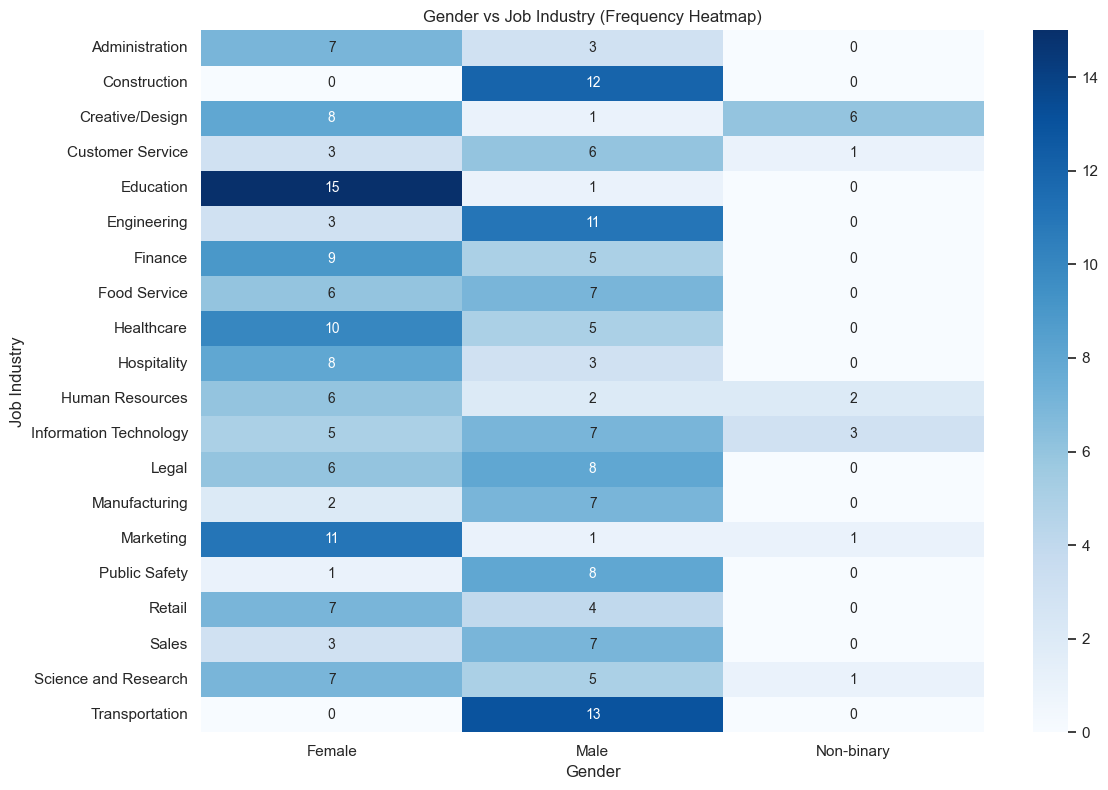

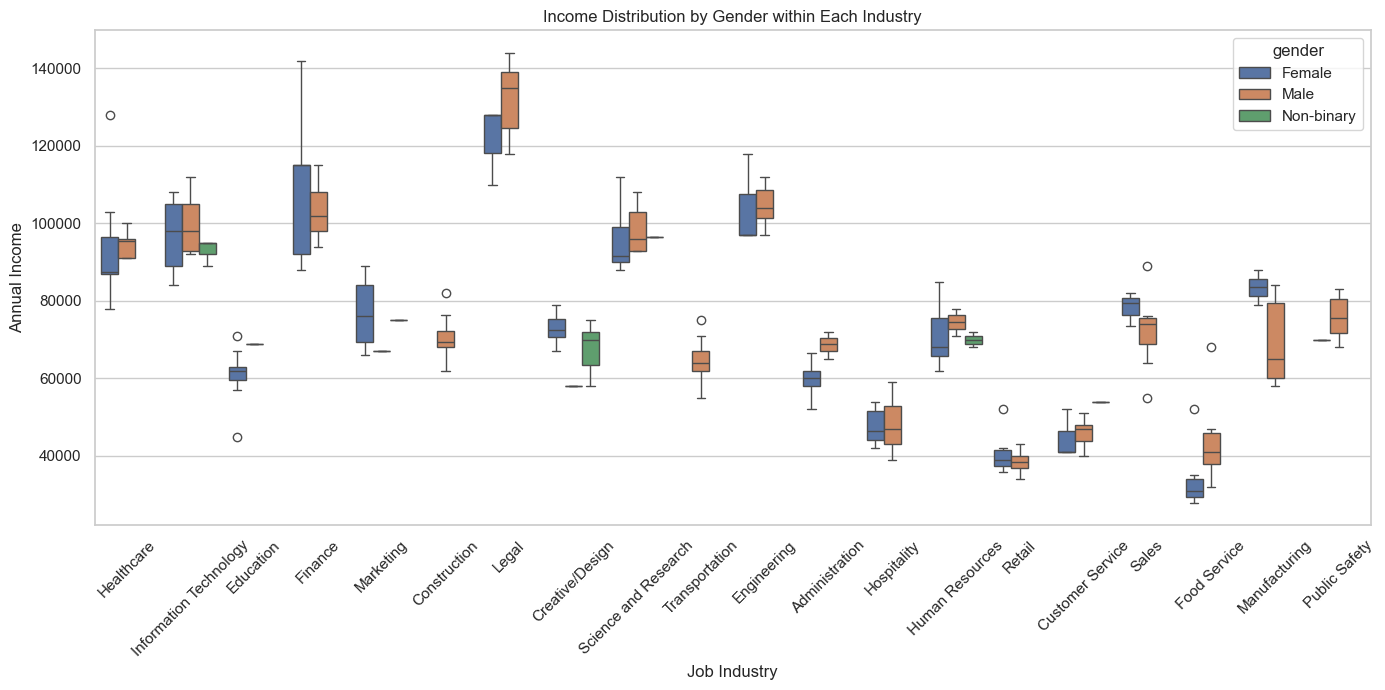

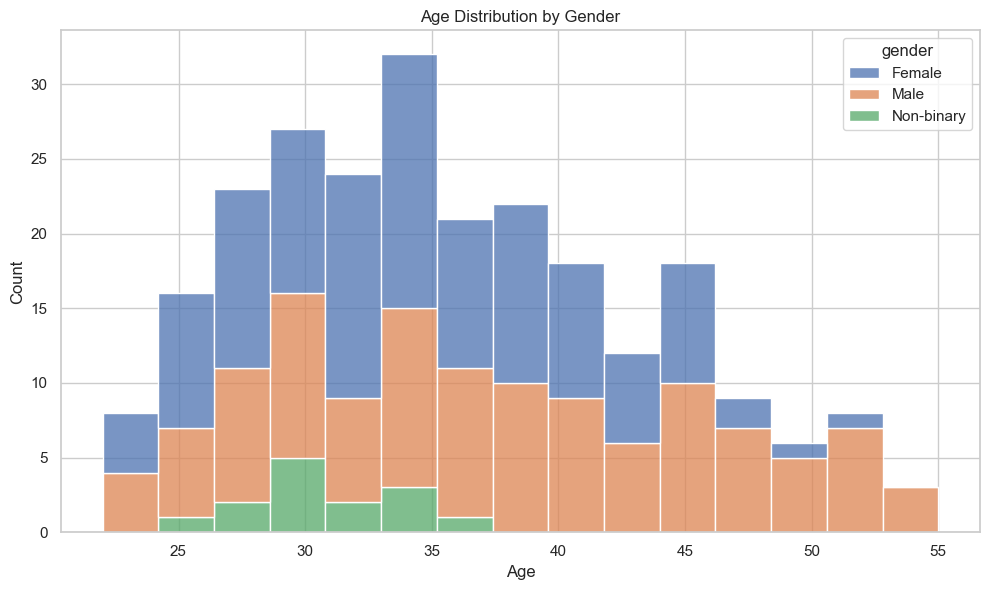

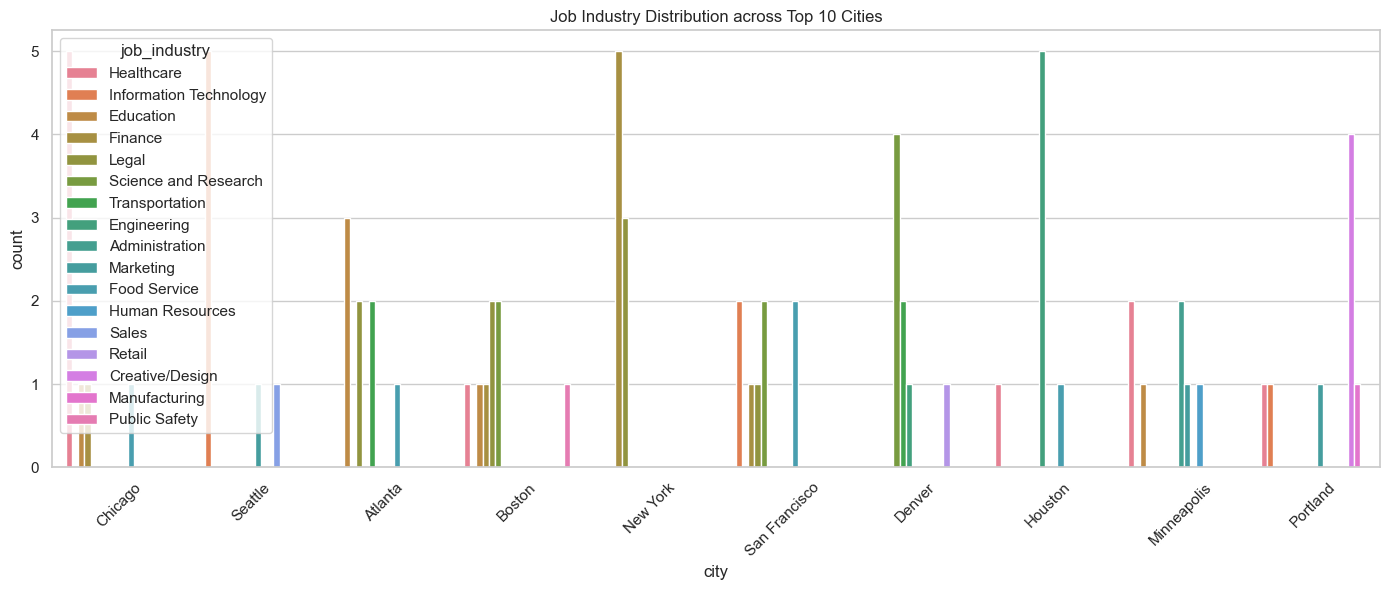

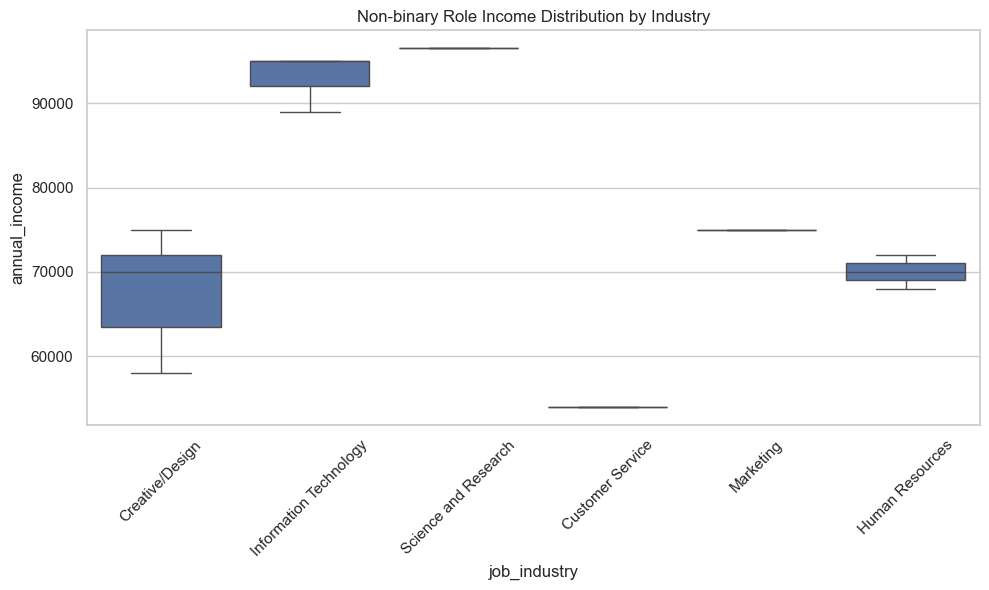

<Figure size 1000x600 with 0 Axes>

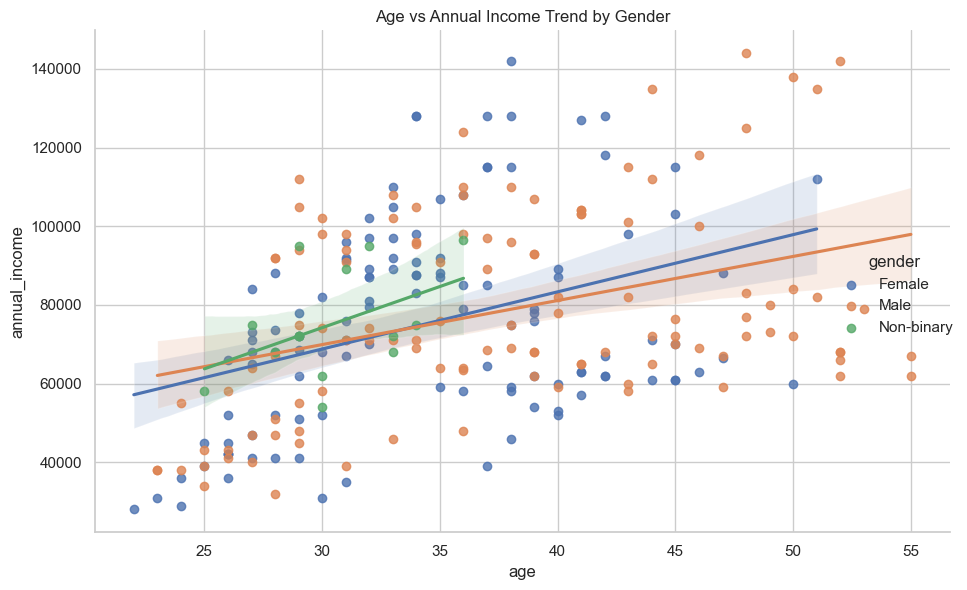

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})
figsize = (10, 6)

plt.figure(figsize=(12, 8))
gender_job_ct = pd.crosstab(df_cleaned['job_industry'], df_cleaned['gender'])
sns.heatmap(gender_job_ct, annot=True, fmt="d", cmap="Blues")
plt.title("Gender vs Job Industry (Frequency Heatmap)")
plt.ylabel("Job Industry")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
subset = df_cleaned[df_cleaned['gender'].isin(['Female', 'Male', 'Non-binary'])]
sns.boxplot(data=subset, x="job_industry", y="annual_income", hue="gender")
plt.title("Income Distribution by Gender within Each Industry")
plt.ylabel("Annual Income")
plt.xlabel("Job Industry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
sns.histplot(data=df_cleaned, x="age", hue="gender", multiple="stack", bins=15)
plt.title("Age Distribution by Gender")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

top_cities = df_cleaned['city'].value_counts().head(10).index
city_industry = df_cleaned[df_cleaned['city'].isin(top_cities)]
plt.figure(figsize=(14, 6))
sns.countplot(data=city_industry, x="city", hue="job_industry")
plt.title("Job Industry Distribution across Top 10 Cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

non_binary_df = df_cleaned[df_cleaned['gender'] == "Non-binary"]
plt.figure(figsize=figsize)
sns.boxplot(data=non_binary_df, x="job_industry", y="annual_income")
plt.title("Non-binary Role Income Distribution by Industry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
sns.lmplot(data=df_cleaned, x="age", y="annual_income", hue="gender", height=6, aspect=1.4)
plt.title("Age vs Annual Income Trend by Gender")
plt.tight_layout()
plt.show()
